# Setup

In [1]:
# Import libraries
import json
import pandas as pd
import numpy as np
import seaborn as sb
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.metrics import median_absolute_error

import statsmodels.api as sm
from statsmodels.api import OLS

In [2]:
data = pd.read_csv('../../data/processed/new_donors.csv', parse_dates=['StartDatetime'])
data['NewDonors'] = data['NewDonors'].astype(float)
data.head()

,StartDatetime,NewDonors
0,2015-01-14,18006.0
1,2015-02-13,19199.0
2,2015-03-15,19471.0
3,2015-04-14,17464.0
4,2015-05-14,17420.0


# Test stationarity

In [3]:
ts = data[data['StartDatetime'].dt.year >= 2017].set_index('StartDatetime')
ts.index.name = 'Time'
ts = ts.squeeze()
ts.head()
# ts['z_data'] = (ts['data'] - ts['data'].rolling(window=12).mean()) / ts['data'].rolling(window=12).std()  # Z-score of data
# ts['zp_data'] = ts['z_data'] - ts['z_data'].shift(12)

Time
2017-01-03    33131.0
2017-02-02    32565.0
2017-03-04    29537.0
2017-04-03    28048.0
2017-05-03    26645.0
Name: NewDonors, dtype: float64

In [4]:
from statsmodels.tsa.stattools import adfuller
 
def test_stationarity(timeseries):
    # Determine rolling stats
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # Plot rolling stats
    plt.figure(figsize=(15, 10))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label = 'Rolling Std')    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    dftest = adfuller(timeseries, autolag='AIC')
    print(f"Test statistic = {dftest[0]}")
    print(f"P-value = {dftest[1]}")
    print("Critical values: ")
    for k, v in dftest[4].items():
        print("\t{}: {}; the data is {} with {}% confidence".format(
            k,
            v,
            "not stationary" if v < dftest[0] else "stationary",
            100-int(k[:-1])))    

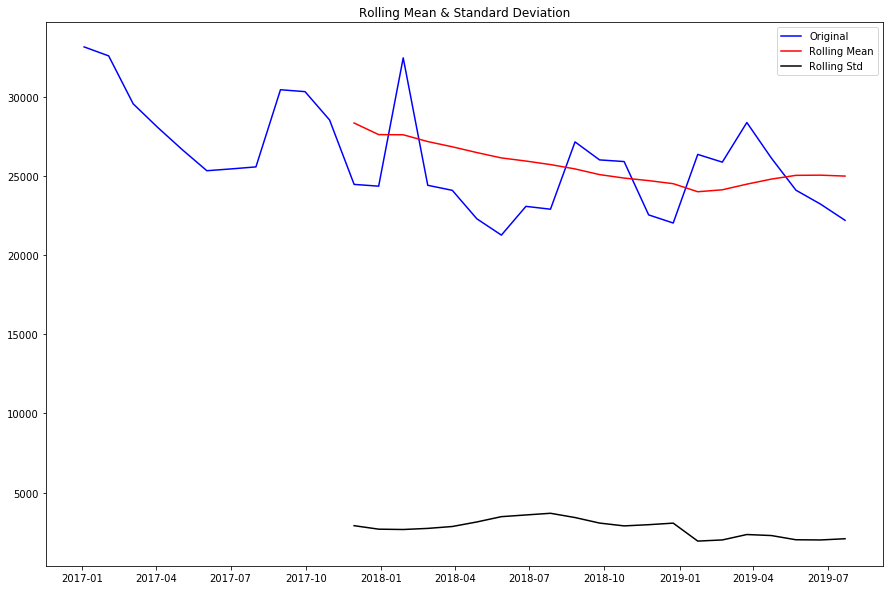

Test statistic = -3.293564200770722
P-value = 0.015168617355082013
Critical values: 
	1%: -3.661428725118324; the data is not stationary with 99% confidence
	5%: -2.960525341210433; the data is stationary with 95% confidence
	10%: -2.6193188033298647; the data is stationary with 90% confidence


In [5]:
test_stationarity(ts)

# Decompose

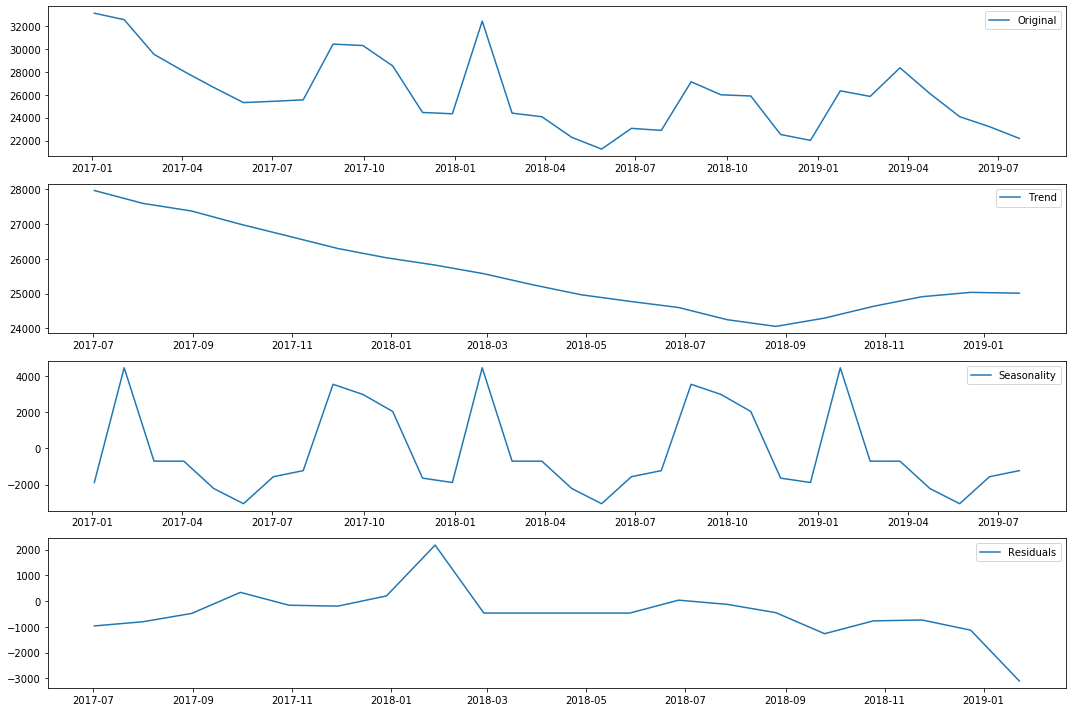

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts, period=12)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig = plt.figure(figsize=(15, 10))

plt.subplot(411)
plt.plot(ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

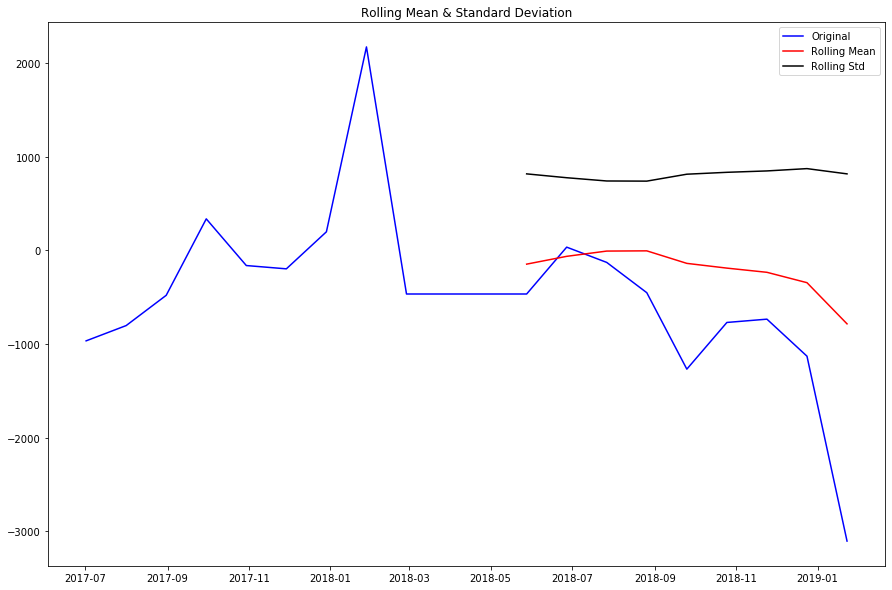

Test statistic = 143.2684037998561
P-value = 1.0
Critical values: 
	1%: -4.223238279489106; the data is not stationary with 99% confidence
	5%: -3.189368925619835; the data is not stationary with 95% confidence
	10%: -2.729839421487603; the data is not stationary with 90% confidence


In [7]:
residual.dropna(inplace=True)
test_stationarity(residual)

In [8]:
ts.head(20)

Time
2017-01-03    33131.0
2017-02-02    32565.0
2017-03-04    29537.0
2017-04-03    28048.0
2017-05-03    26645.0
2017-06-02    25319.0
2017-07-02    25434.0
2017-08-01    25560.0
2017-08-31    30428.0
2017-09-30    30308.0
2017-10-30    28521.0
2017-11-29    24456.0
2017-12-29    24344.0
2018-01-28    32440.0
2018-02-27    24399.0
2018-03-29    24081.0
2018-04-28    22285.0
2018-05-28    21256.0
2018-06-27    23070.0
2018-07-27    22890.0
Name: NewDonors, dtype: float64

# Clean up outliers

For any points with residuals outside "normal" bounds (below the 10th percentile and above the 90th percentile), perform linear interpolation.

In [9]:
# Compute 10th and 90th percentiles
q_10 = np.quantile(residual, 0.1)
q_90 = np.quantile(residual, 0.9)

In [10]:
# Find outliers
residual_outliers = residual[(residual < q_10) | (residual > q_90)]
residual_outliers

Time
2017-09-30     337.744792
2018-01-28    2176.119792
2018-09-25   -1268.921875
2019-01-23   -3107.296875
Name: resid, dtype: float64

In [11]:
residual_outliers_mask = ts.index.isin(residual_outliers.index)
residual_outliers_mask

array([False, False, False, False, False, False, False, False, False,
        True, False, False, False,  True, False, False, False, False,
       False, False, False,  True, False, False, False,  True, False,
       False, False, False, False, False])

In [12]:
ts[residual_outliers_mask] - seasonal[residual_outliers_mask]

Time
2017-09-30    27330.953125
2018-01-28    27993.869792
2018-09-25    23023.953125
2019-01-23    21901.869792
dtype: float64

In [13]:
corrections = pd.DataFrame(ts).merge(seasonal, how='left', left_index=True, right_index=True) \
                              .merge(trend, how='left', left_index=True, right_index=True) \
                              .merge(residual, how='left', left_index=True, right_index=True)                              
corrections['is_outlier'] = corrections.index.isin(residual_outliers.index)
corrections['interpolated_resid'] = corrections.apply(lambda row: None if row['is_outlier'] == True else row['resid'], axis=1)
corrections.head(24)

,NewDonors,seasonal,trend,resid,is_outlier,interpolated_resid
Time,,,,,,
2017-01-03,33131.0,-1882.848958,NaN,NaN,False,NaN
2017-02-02,32565.0,4446.130208,NaN,NaN,False,NaN
2017-03-04,29537.0,-704.786458,NaN,NaN,False,NaN
2017-04-03,28048.0,-706.203125,NaN,NaN,False,NaN
2017-05-03,26645.0,-2213.411458,NaN,NaN,False,NaN
2017-06-02,25319.0,-3052.869792,NaN,NaN,False,NaN
2017-07-02,25434.0,-1562.703125,27963.208333,-966.505208,False,-966.505208
2017-08-01,25560.0,-1228.682292,27591.875000,-803.192708,False,-803.192708
2017-08-31,30428.0,3534.942708,27372.583333,-479.526042,False,-479.526042


In [14]:
corrections['interpolated_resid'].interpolate(method='linear', inplace=True)
corrections.head(24)

,NewDonors,seasonal,trend,resid,is_outlier,interpolated_resid
Time,,,,,,
2017-01-03,33131.0,-1882.848958,NaN,NaN,False,NaN
2017-02-02,32565.0,4446.130208,NaN,NaN,False,NaN
2017-03-04,29537.0,-704.786458,NaN,NaN,False,NaN
2017-04-03,28048.0,-706.203125,NaN,NaN,False,NaN
2017-05-03,26645.0,-2213.411458,NaN,NaN,False,NaN
2017-06-02,25319.0,-3052.869792,NaN,NaN,False,NaN
2017-07-02,25434.0,-1562.703125,27963.208333,-966.505208,False,-966.505208
2017-08-01,25560.0,-1228.682292,27591.875000,-803.192708,False,-803.192708
2017-08-31,30428.0,3534.942708,27372.583333,-479.526042,False,-479.526042


In [15]:
corrections['AdjustedNewDonors'] = corrections['interpolated_resid'] + corrections['seasonal'] + corrections['trend']
corrections['AdjustedNewDonors'] = corrections.apply(lambda row: row['NewDonors'] if pd.isna(row['AdjustedNewDonors']) else row['AdjustedNewDonors'], axis=1)
corrections.head(24)

,NewDonors,seasonal,trend,resid,is_outlier,interpolated_resid,AdjustedNewDonors
Time,,,,,,,
2017-01-03,33131.0,-1882.848958,NaN,NaN,False,NaN,33131.000000
2017-02-02,32565.0,4446.130208,NaN,NaN,False,NaN,32565.000000
2017-03-04,29537.0,-704.786458,NaN,NaN,False,NaN,29537.000000
2017-04-03,28048.0,-706.203125,NaN,NaN,False,NaN,28048.000000
2017-05-03,26645.0,-2213.411458,NaN,NaN,False,NaN,26645.000000
2017-06-02,25319.0,-3052.869792,NaN,NaN,False,NaN,25319.000000
2017-07-02,25434.0,-1562.703125,27963.208333,-966.505208,False,-966.505208,25434.000000
2017-08-01,25560.0,-1228.682292,27591.875000,-803.192708,False,-803.192708,25560.000000
2017-08-31,30428.0,3534.942708,27372.583333,-479.526042,False,-479.526042,30428.000000


In [16]:
adjusted_ts = corrections['AdjustedNewDonors']
adjusted_ts.head(12)

Time
2017-01-03    33131.0000
2017-02-02    32565.0000
2017-03-04    29537.0000
2017-04-03    28048.0000
2017-05-03    26645.0000
2017-06-02    25319.0000
2017-07-02    25434.0000
2017-08-01    25560.0000
2017-08-31    30428.0000
2017-09-30    29649.8125
2017-10-30    28521.0000
2017-11-29    24456.0000
Name: AdjustedNewDonors, dtype: float64

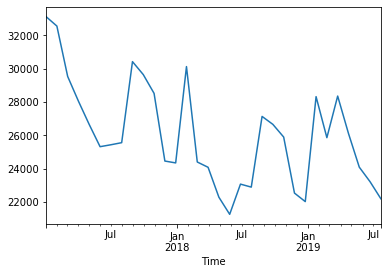

In [17]:
adjusted_ts.plot()

# Test stationarity

Testing whether the data is stationary will help us determine what methods can/should be used. ARIMA, for example, should only be used if the data is stationary.

In [18]:
from statsmodels.tsa.stattools import adfuller

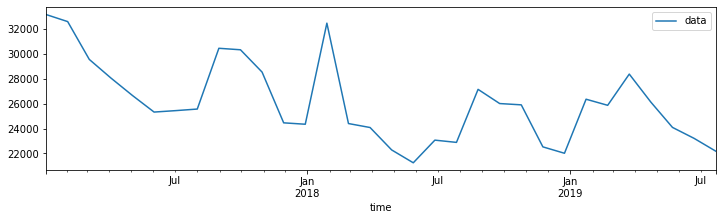

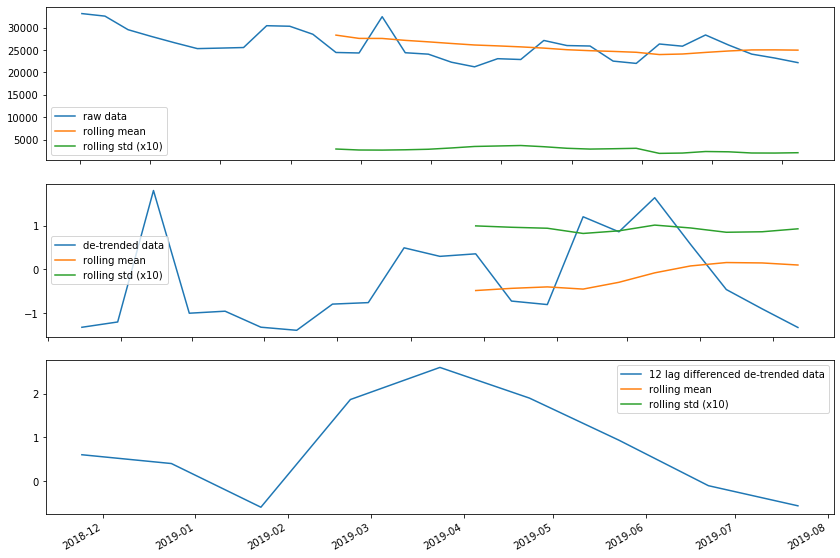

In [19]:
# df = pd.DataFrame(adjusted_ts)
df = pd.DataFrame(ts)
df.index.name = 'time'
df.columns = ['data']
train = df.iloc[:-10, :]
test = df.iloc[-10:, :]
pred = test.copy()
df.plot(figsize=(12,3));

df['z_data'] = (df['data'] - df['data'].rolling(window=12).mean()) / df['data'].rolling(window=12).std()  # Z-score of data
df['zp_data'] = df['z_data'] - df['z_data'].shift(12)

def plot_rolling(df):
    fig, ax = plt.subplots(3,figsize=(12, 9))
    ax[0].plot(df.index, df['data'], label='raw data')
    ax[0].plot(df['data'].rolling(window=12).mean(), label="rolling mean");
    ax[0].plot(df['data'].rolling(window=12).std(), label="rolling std (x10)");
    ax[0].legend()

    ax[1].plot(df.index, df['z_data'], label="de-trended data")
    ax[1].plot(df['z_data'].rolling(window=12).mean(), label="rolling mean");
    ax[1].plot(df['z_data'].rolling(window=12).std(), label="rolling std (x10)");
    ax[1].legend()

    ax[2].plot(df.index, df['zp_data'], label="12 lag differenced de-trended data")
    ax[2].plot(df['zp_data'].rolling(window=12).mean(), label="rolling mean");
    ax[2].plot(df['zp_data'].rolling(window=12).std(), label="rolling std (x10)");
    ax[2].legend()

    plt.tight_layout()
    fig.autofmt_xdate()
    
plot_rolling(df)

In [20]:
print(" > Is the data stationary ?")
dftest = adfuller(df['data'], autolag='AIC')
print(f"Test statistic = {dftest[0]}")
print(f"P-value = {dftest[1]}")
print("Critical values: ")
for k, v in dftest[4].items():
    print("\t{}: {}; the data is {} with {}% confidence".format(
        k,
        v,
        "not stationary" if v < dftest[0] else "stationary",
        100-int(k[:-1])))    
    
print("\n > Is the de-trended data stationary ?")
dftest = adfuller(df['z_data'].dropna(), autolag='AIC')
print(f"Test statistic = {format(dftest[0])}")
print(f"P-value = {format(dftest[1])}")
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} with {}% confidence".format(
        k,
        v,
        "not stationary" if v < dftest[0] else "stationary",
        100-int(k[:-1])))
    
print("\n > Is the 12-lag differenced de-trended data stationary ?")
dftest = adfuller(df['zp_data'].dropna(), autolag='AIC')
print(f"Test statistic = {format(dftest[0])}")
print(f"P-value = {format(dftest[1])}")
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {}; the data is {} with {}% confidence".format(
        k,
        v,
        "not stationary" if v < dftest[0] else "stationary",
        100-int(k[:-1])))    

 > Is the data stationary ?
Test statistic = -3.293564200770722
P-value = 0.015168617355082013
Critical values: 
	1%: -3.661428725118324; the data is not stationary with 99% confidence
	5%: -2.960525341210433; the data is stationary with 95% confidence
	10%: -2.6193188033298647; the data is stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -1.605126870177714
P-value = 0.481017608711806
Critical values :
	1%: -3.9240193847656246 - The data is not stationary with 99% confidence
	5%: -3.0684982031250003 - The data is not stationary with 95% confidence
	10%: -2.67389265625 - The data is not stationary with 90% confidence

 > Is the 12-lag differenced de-trended data stationary ?
Test statistic = -2.6758476042227453
P-value = 0.07831174575958182
Critical values :
	1%: -5.354256481481482; the data is not stationary with 99% confidence
	5%: -3.6462381481481483; the data is not stationary with 95% confidence
	10%: -2.901197777777778; the data is not statio

C:\Users\rthrw\miniconda3\envs\oneblood-inventory\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


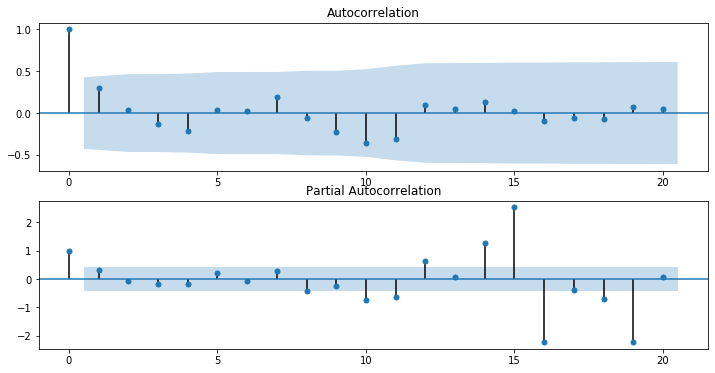

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(df['z_data'].dropna(), ax=ax[0], lags=20)
ax[1] = plot_pacf(df['z_data'].dropna(), ax=ax[1], lags=20)

# ARIMA

## Choose differencing order (d param)

C:\Users\rthrw\miniconda3\envs\oneblood-inventory\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 30D will be used.
  % freq, ValueWarning)
C:\Users\rthrw\miniconda3\envs\oneblood-inventory\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 30D will be used.
  % freq, ValueWarning)
C:\Users\rthrw\miniconda3\envs\oneblood-inventory\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 30D will be used.
  % freq, ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                   data   No. Observations:                   32
Model:                     ARMA(0, 0)   Log Likelihood                -303.525
Method:                           css   S.D. of innovations           3185.065
Date:                Sun, 12 Jul 2020   AIC                            611.051
Time:                        20:40:41   BIC                            613.982
Sample:                    01-03-2017   HQIC                           612.022
                         - 07-22-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.608e+04    563.045     46.315      0.000     2.5e+04    2.72e+04
                             ARIMA Model Results                              
Dep. Variable:                 D.data   No. Observat

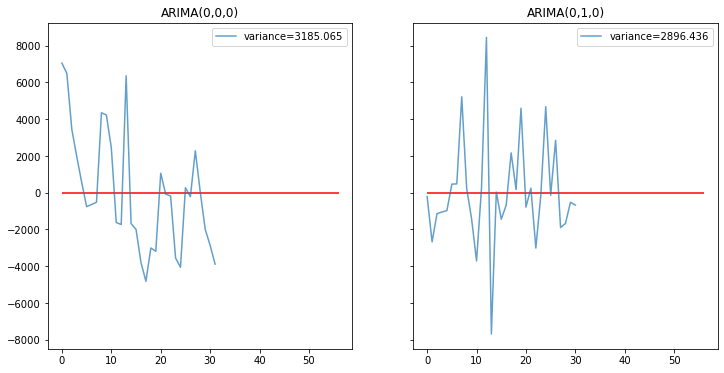

In [22]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(df['data'].dropna(), (0, 0, 0))
res_000 = model.fit()
print(res_000.summary())

model = ARIMA(df['data'].dropna(), (0, 1, 0))
res_010 = model.fit()
print(res_010.summary())

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
ax[0].plot(res_000.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_000.resid.values)));
ax[0].hlines(0, xmin=0, xmax=56, color='r');
ax[0].set_title("ARIMA(0,0,0)");
ax[0].legend();
ax[1].plot(res_010.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_010.resid.values)));
ax[1].hlines(0, xmin=0, xmax=56, color='r');
ax[1].set_title("ARIMA(0,1,0)");
ax[1].legend();

## Choose MA order (p param)

C:\Users\rthrw\miniconda3\envs\oneblood-inventory\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 30D will be used.
  % freq, ValueWarning)
C:\Users\rthrw\miniconda3\envs\oneblood-inventory\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 30D will be used.
  % freq, ValueWarning)
C:\Users\rthrw\miniconda3\envs\oneblood-inventory\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 30D will be used.
  % freq, ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                   data   No. Observations:                   32
Model:                     ARMA(0, 0)   Log Likelihood                -303.525
Method:                           css   S.D. of innovations           3185.065
Date:                Sun, 12 Jul 2020   AIC                            611.051
Time:                        20:40:41   BIC                            613.982
Sample:                    01-03-2017   HQIC                           612.022
                         - 07-22-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.608e+04    563.045     46.315      0.000     2.5e+04    2.72e+04
                             ARIMA Model Results                              
Dep. Variable:                 D.data   No. Observat

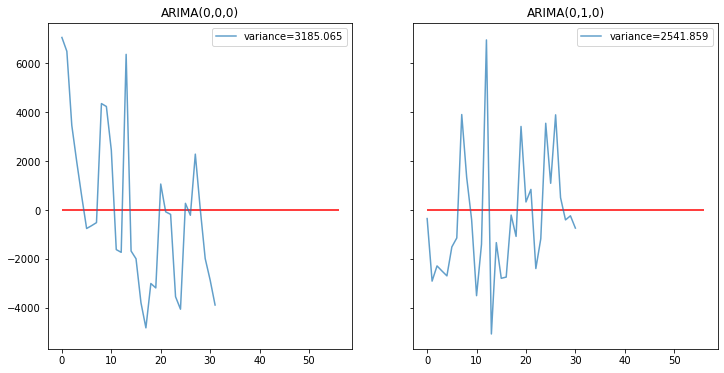

In [23]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(df['data'].dropna(), (0, 0, 0))
res_000 = model.fit()
print(res_000.summary())

model = ARIMA(df['data'].dropna(), (1, 1, 1))
res_010 = model.fit()
print(res_010.summary())

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
ax[0].plot(res_000.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_000.resid.values)));
ax[0].hlines(0, xmin=0, xmax=56, color='r');
ax[0].set_title("ARIMA(0,0,0)");
ax[0].legend();
ax[1].plot(res_010.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_010.resid.values)));
ax[1].hlines(0, xmin=0, xmax=56, color='r');
ax[1].set_title("ARIMA(0,1,0)");
ax[1].legend();

## Choose AR order (q param)

C:\Users\rthrw\miniconda3\envs\oneblood-inventory\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 30D will be used.
  % freq, ValueWarning)
C:\Users\rthrw\miniconda3\envs\oneblood-inventory\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 30D will be used.
  % freq, ValueWarning)
C:\Users\rthrw\miniconda3\envs\oneblood-inventory\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 30D will be used.
  % freq, ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                   data   No. Observations:                   32
Model:                     ARMA(0, 0)   Log Likelihood                -303.525
Method:                           css   S.D. of innovations           3185.065
Date:                Sun, 12 Jul 2020   AIC                            611.051
Time:                        20:40:42   BIC                            613.982
Sample:                    01-03-2017   HQIC                           612.022
                         - 07-22-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.608e+04    563.045     46.315      0.000     2.5e+04    2.72e+04
                             ARIMA Model Results                              
Dep. Variable:                 D.data   No. Observat

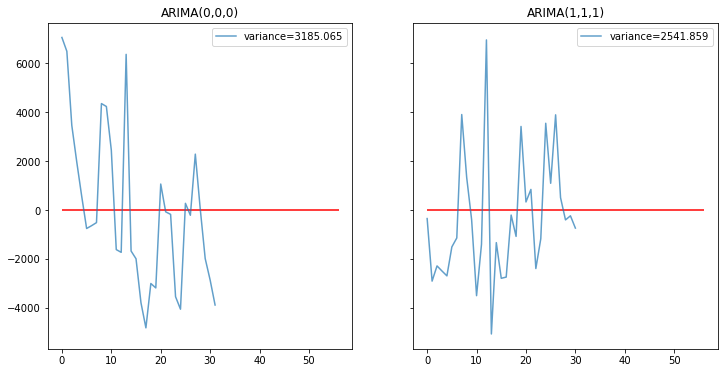

In [24]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(df['data'].dropna(), (0, 0, 0))
res_000 = model.fit()
print(res_000.summary())

model = ARIMA(df['data'].dropna(), (1, 1, 1))
res_010 = model.fit()
print(res_010.summary())

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
ax[0].plot(res_000.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_000.resid.values)));
ax[0].hlines(0, xmin=0, xmax=56, color='r');
ax[0].set_title("ARIMA(0,0,0)");
ax[0].legend();
ax[1].plot(res_010.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_010.resid.values)));
ax[1].hlines(0, xmin=0, xmax=56, color='r');
ax[1].set_title("ARIMA(1,1,1)");
ax[1].legend();